## **A. Kaggle dataset import**

**1. We have to install the Kaggle package that will be used for importing the data.**

In [135]:
! pip install -q kaggle

**2. Next, we have to save the json file with the api credential on your computer and upload the file to Colab using the code below:**

In [136]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"hyunjunlee2019310995","key":"aeeabb4bd29b3436e56bb3cb1a870cd5"}'}

**3. The Kaggle API client expects the json file to be in ~/.kaggle folder so we created a new folder and move it inside.**

In [137]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


**4. Then paste 'API Command' of code in our notebook as below:**

In [138]:
! kaggle datasets download -d ishantjuyal/emotions-in-text

emotions-in-text.zip: Skipping, found more recently modified local copy (use --force to force download)


## **B. Importing libraries**

In [139]:
import pickle
import re
import string
import time
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **C. Get dataset from Kaggle**

In [140]:
# Decompress into a pandas dataframe
import zipfile
zip_ref = zipfile.ZipFile("emotions-in-text.zip", "r")
zip_ref.extractall("files")
zip_ref.close()
import pandas as pd
df=pd.read_csv("/content/files/Emotion_final.csv")

In [141]:
# Head of the dataset
df.head(10)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,happy
9,i feel romantic too,love


**1. See the amount of data we have to analyze**

In [142]:
print("Amount of data:", df.shape[0])

Amount of data: 21459


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


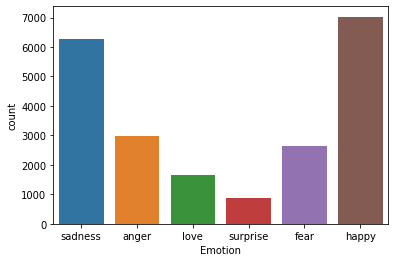

In [143]:
sns.countplot(df.Emotion)
plt.show()

In [144]:
# Get a shuffled sample of the dataframe
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
dataset = df[:15000]
test_dataset = df[15000:]
dataset.head()

,Text,Emotion
0,im just not mentally there but can still feel ...,happy
1,i love a hearty chat where i mean everything t...,happy
2,i am feeling brave we will go somewhere furthe...,happy
3,When one day nobody could rouse him from his t...,sadness
4,i sit here feeling annoyed at my sons my pets ...,anger


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


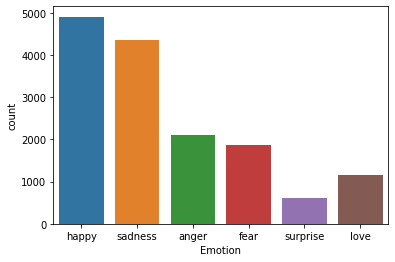

In [145]:
sns.countplot(dataset.Emotion)
plt.show()

## **D. Preprocessing**

In [146]:
# Using one hot encoding to transfrom categorical data into a number that represents the category
one_hot = pd.get_dummies(dataset['Emotion'])
dataset = dataset.join(one_hot)


In [147]:
# Convert that one hot encoding into a vector list
dataset['Label'] = dataset[['anger', 'fear', 'happy','love', 'sadness', 'surprise']].values.tolist()
dataset = dataset.drop(columns = ['Emotion','anger', 'fear', 'happy','love', 'sadness', 'surprise'])
dataset.head(5)

,Text,Label
0,im just not mentally there but can still feel ...,"[0, 0, 1, 0, 0, 0]"
1,i love a hearty chat where i mean everything t...,"[0, 0, 1, 0, 0, 0]"
2,i am feeling brave we will go somewhere furthe...,"[0, 0, 1, 0, 0, 0]"
3,When one day nobody could rouse him from his t...,"[0, 0, 0, 0, 1, 0]"
4,i sit here feeling annoyed at my sons my pets ...,"[1, 0, 0, 0, 0, 0]"


In [148]:
# Function to clean text of any unwanted symbols and punctuation marks
def cleaning_text(text):
    text = text.lower()
    text = re.sub('r<.*?>', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'http\S+', " ", text)

    text = text.split()
    stop_words = stopwords.words("english")
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")

    return text

dataset['Text'] = dataset['Text'].apply(lambda x: cleaning_text(x))

## **E. BERT model**

In [149]:
# Install transformers
!pip install -q transformers

In [150]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [151]:
from torch.utils.data import Dataset
max_len = 32
# Class PrepDataset to format the dataset to feed the BERT model
class PrepDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Text']
        self.targets = self.data.Label
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [152]:
#Split 8:2 ratio train-validation
train_size = 0.8
train_dataset = dataset.sample(frac=train_size,random_state=200)
valid_dataset = dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
training_set = PrepDataset(train_dataset, tokenizer, max_len)
validation_set = PrepDataset(valid_dataset, tokenizer, max_len)
training_loader = DataLoader(training_set, batch_size=30)
validation_loader = DataLoader(validation_set, batch_size=30)

In [153]:
# BERT model class
from transformers import BertModel
class BERT(torch.nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [154]:
# Verify the use of GPU in google colab
device_name = tf.test.gpu_device_name()
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [155]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [156]:
# Training
epochs = 4
learning_rate = 0.0001
model = BERT()
model.to(device)
len_trainloader = len(training_loader)
loss_f = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_loss = 0
valid_loss = 0
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
for epoch in range(epochs):
  avg_loss = 0
  items = 0
  for batch_idx, data in enumerate(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
  print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Training Loss:  0.08621962368488312
Epoch: 1, Training Loss:  0.03260810673236847
Epoch: 2, Training Loss:  0.011325656436383724
Epoch: 3, Training Loss:  0.06968393176794052


In [157]:
val_targets=[]
val_outputs=[]
valid_loss=0

In [158]:
# Validation
model.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(validation_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
        val_targets.extend(targets.cpu().detach().numpy().tolist())
        val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

In [159]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1 = metrics.f1_score(val_targets, val_preds, average='micro')

In [160]:
# Accuracy and F1 score of the model
print("Accuracy: " +str(accuracy))
print("F1 Score: " +str(f1))

Accuracy: 0.8973333333333333
F1 Score: 0.9063758389261745


In [161]:
# Prepare the prediction dataset for the model for the test
class PredictionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Text']
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }

In [162]:
# Function to use the model with the test dataset
def do_prediction(loader):
    model.eval()
    pred_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            pred_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return pred_outputs

In [164]:
# Test data preprocessing 
test_dataset['Text'] = test_dataset['Text'].apply(lambda x: cleaning_text(x))
test_actual = pd.get_dummies(test_dataset['Emotion'])
test_actual['Label'] = test_actual[['anger', 'fear', 'happy','love', 'sadness', 'surprise']].values.tolist()
test_actual = test_actual.drop(columns = ['anger', 'fear', 'happy','love', 'sadness', 'surprise'])
test_dataset = test_dataset.drop(columns = ['Emotion'])
test_dataset = test_dataset.reset_index(drop=True)
test_set = PredictionDataset(test_dataset, tokenizer, max_len)
testing_loader = DataLoader(test_set, batch_size=30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [176]:
# Concatenate the predictions with the test dataset
pred_outputs = do_prediction(testing_loader)
pred_outputs = (np.array(pred_outputs) >= 0.5).astype(int)
preds_df = pd.DataFrame(pred_outputs, columns =['anger', 'fear', 'happy','love', 'sadness', 'surprise'])
df_concat = pd.concat([test_dataset, preds_df], axis=1)

In [177]:
# Accuracy of predicted test data vs actual test data
actual = test_actual['Label'].tolist()
accuracy_test = metrics.accuracy_score(actual, pred_outputs)

In [178]:
accuracy_test

0.9006038086391083